### In this notebook, we will work with information about the application_train and application_test tables

#### I will follow the road map
    
    1 - Import the data
    2 - Exploratory data analysis
    3 - Label encoding
    4 - One hot encoding
    5 - Feature Engineering
    6 - Dropping correlated features (> 0.6)
    7 - Dropping missing features (> 0.6)
    8 - Run Logistic regression to be the benchmark
    9 - Run RandomForestClassifier to get features importance
    10 - Run first time Light GBM 
    


# Starting with the data 

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os
import gc

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import MinMaxScaler, Imputer

from sklearn.ensemble import RandomForestClassifier


from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

import itertools



#### 2.1.1- Import the data

In [2]:
path = '/home/ralph/Documents/UDACITY/Machine_Learning/Capstone Project/Data/all/'
out_path = '/home/ralph/Documents/UDACITY/Machine_Learning/Capstone Project/output/'
submission  = '/home/ralph/Documents/UDACITY/Machine_Learning/Capstone Project/'

In [3]:
#list all dataframe 
print(os.listdir(path))

['HomeCredit_columns_description.csv', 'credit_card_balance.csv', 'bureau.csv', 'POS_CASH_balance.csv', 'application_test.csv', 'bureau_balance.csv', 'log_reg_baseline.csv', 'sample_submission.csv', '.~lock.HomeCredit_columns_description.csv#', 'installments_payments.csv', 'previous_application.csv', 'application_train.csv']


In [4]:
# Importing Training data
app_train = pd.read_csv(path+'application_train.csv')
print('Training data shape: ', app_train.shape)
print(app_train.info(memory_usage=True))

Training data shape:  (307511, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


In [5]:
# save the target variable to be used in another moment
target = app_train['TARGET']

In [6]:
# Create a train dataframe as reference
app_train_aux = app_train[['SK_ID_CURR']]
app_train_aux = pd.DataFrame(app_train_aux)
app_train_aux.head()

,SK_ID_CURR
0,100002
1,100003
2,100004
3,100006
4,100007


In [7]:
#Importing Testing data features
app_test = pd.read_csv(path+'application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()
print(app_train.info(memory_usage=True))

Testing data shape:  (48744, 121)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


In [8]:
# Create a test dataframe as reference
app_test_aux = app_test[['SK_ID_CURR']]
app_test_aux = pd.DataFrame(app_test_aux)
app_test_aux.head()

,SK_ID_CURR
0,100001
1,100005
2,100013
3,100028
4,100038


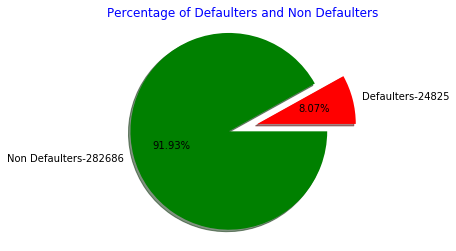

In [9]:
#Understanding target/dependent variable
pie_labels=['Defaulters-'+str(app_train['TARGET'][app_train.TARGET==1].count()),'Non Defaulters-'+str(app_train['TARGET'][app_train.TARGET==0].count())]
pie_share=[app_train['TARGET'][app_train.TARGET==1].count()/app_train['TARGET'].count(),
           app_train['TARGET'][app_train.TARGET==0].count()/app_train['TARGET'].count()]
figureObject, axesObject = plt.subplots()
pie_colors=('red','green')
pie_explode=(.3,.0)
axesObject.pie(pie_share,labels=pie_labels,explode=pie_explode,autopct='%.2f%%',colors=pie_colors,startangle=0,shadow=True)
axesObject.axis('equal')
plt.title('Percentage of Defaulters and Non Defaulters',color='blue')
plt.show()

# EAD - Exploratory data Analysis in Train and Test Data Frame

## In this section, some graphics will be built to help understand the data 



In [10]:
app_test.shape

(48744, 121)

In [11]:
# Observing columns type
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [12]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [13]:
app_train["type"] = "train"
app_test["type"]  =  "test"

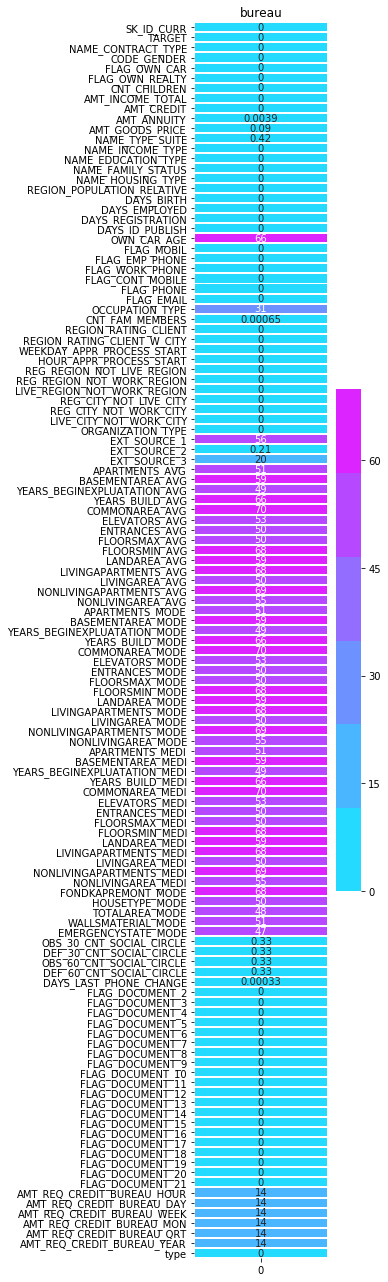

In [14]:
#Observing percentual of missing values in each Column
plt.figure(figsize=(15,50))

plt.subplot(231)
sns.heatmap(pd.DataFrame(app_train.isnull().sum()/app_train.shape[0]*100),annot=True,
            cmap=sns.color_palette("cool"),linewidth=1,linecolor="white")
plt.title("bureau")

plt.subplots_adjust(wspace = 1)

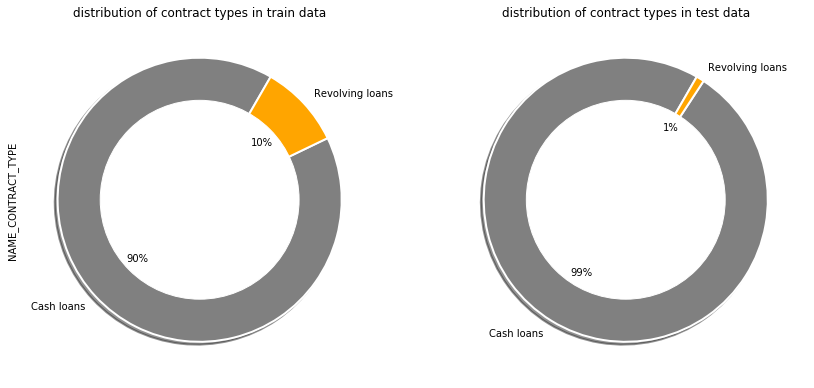

In [15]:
# distribution of contract types
plt.figure(figsize=(14,7))
plt.subplot(121)
app_train[app_train["type"] == "train"]["NAME_CONTRACT_TYPE"].value_counts().plot.pie(autopct = "%1.0f%%",colors = ["grey","orange"],startangle = 60,wedgeprops={"linewidth":2,"edgecolor":"white"},shadow =True)
circ = plt.Circle((0,0),.7,color="white")
plt.gca().add_artist(circ)
plt.title("distribution of contract types in train data")

plt.subplot(122)
app_test[app_test["type"] == "test"]["NAME_CONTRACT_TYPE"].value_counts().plot.pie(autopct = "%1.0f%%",colors = ["grey","orange"],startangle = 60,wedgeprops={"linewidth":2,"edgecolor":"white"},shadow =True)
circ = plt.Circle((0,0),.7,color="white")
plt.gca().add_artist(circ)
plt.ylabel("")
plt.title("distribution of contract types in test data")
plt.show()

Text(0.5, 1.0, 'distribution of gender in test data')

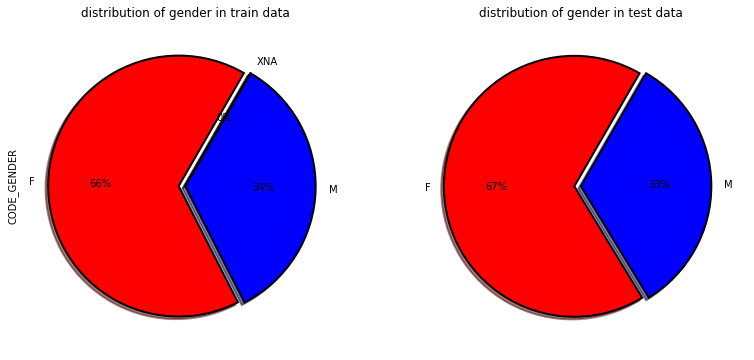

In [16]:
#distribution of gender
fig = plt.figure(figsize=(13,6))
plt.subplot(121)
app_train[app_train["type"] == "train"]["CODE_GENDER"].value_counts().plot.pie(autopct = "%1.0f%%",colors = ["r","b"],startangle = 60,wedgeprops={"linewidth":2,"edgecolor":"k"},explode=[.05,0,0],shadow =True)
plt.title("distribution of gender in train data")

plt.subplot(122)
app_test[app_test["type"] == "test"]["CODE_GENDER"].value_counts().plot.pie(autopct = "%1.0f%%",colors = ["r","b"],startangle = 60,wedgeprops={"linewidth":2,"edgecolor":"k"},explode=[.05,0],shadow =True)
plt.ylabel("")
plt.title("distribution of gender in test data")
#fig.set_facecolor("lightgrey")

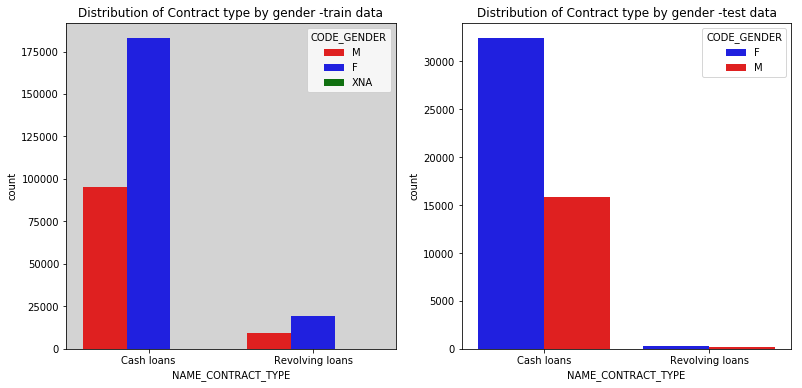

In [17]:
# Distribution of Contract type
fig  = plt.figure(figsize=(13,6))
plt.subplot(121)
ax = sns.countplot("NAME_CONTRACT_TYPE",hue="CODE_GENDER",data=app_train[app_train["type"] == "train"],palette=["r","b","g"])
ax.set_facecolor("lightgrey")
ax.set_title("Distribution of Contract type by gender -train data")

plt.subplot(122)
ax1 = sns.countplot("NAME_CONTRACT_TYPE",hue="CODE_GENDER",data=app_test[app_test["type"] == "test"],palette=["b","r"])
ax1.set_title("Distribution of Contract type by gender -test data")
plt.show()

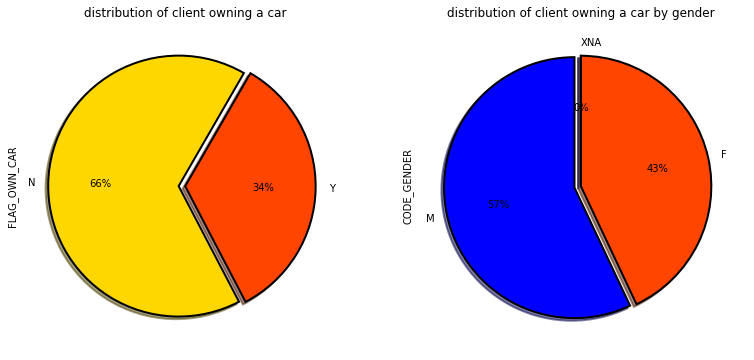

In [18]:
# distribution of client owning a car
fig = plt.figure(figsize=(13,6))

plt.subplot(121)
app_train["FLAG_OWN_CAR"].value_counts().plot.pie(autopct = "%1.0f%%",colors = ["gold","orangered"],startangle = 60,
                                                  wedgeprops={"linewidth":2,"edgecolor":"k"},explode=[.05,0],shadow =True)
plt.title("distribution of client owning a car")

plt.subplot(122)
app_train[app_train["FLAG_OWN_CAR"] == "Y"]["CODE_GENDER"].value_counts().plot.pie(autopct = "%1.0f%%",colors = ["b","orangered"],startangle = 90,
                                                                        wedgeprops={"linewidth":2,"edgecolor":"k"},explode=[.05,0,0],shadow =True)
plt.title("distribution of client owning a car by gender")

plt.show()

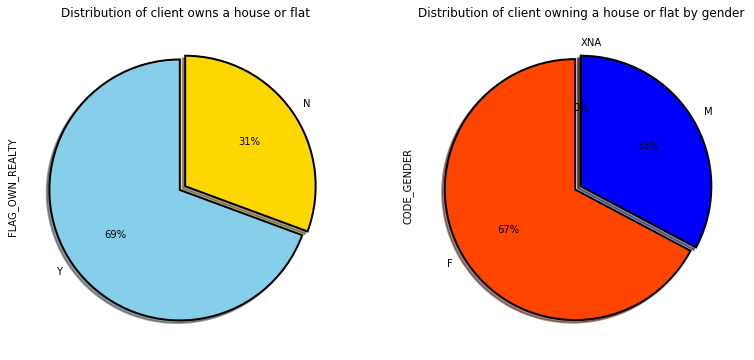

In [19]:
# Distribution of client owning a house or flat by gender
plt.figure(figsize=(13,6))
plt.subplot(121)
app_train["FLAG_OWN_REALTY"].value_counts().plot.pie(autopct = "%1.0f%%",colors = ["skyblue","gold"],startangle = 90,
                                              wedgeprops={"linewidth":2,"edgecolor":"k"},explode=[0.05,0],shadow =True)
plt.title("Distribution of client owns a house or flat")

plt.subplot(122)
app_train[app_train["FLAG_OWN_REALTY"] == "Y"]["CODE_GENDER"].value_counts().plot.pie(autopct = "%1.0f%%",colors = ["orangered","b"],startangle = 90,
                                                                        wedgeprops={"linewidth":2,"edgecolor":"k"},explode=[.05,0,0],shadow =True)
plt.title("Distribution of client owning a house or flat by gender")
plt.show()

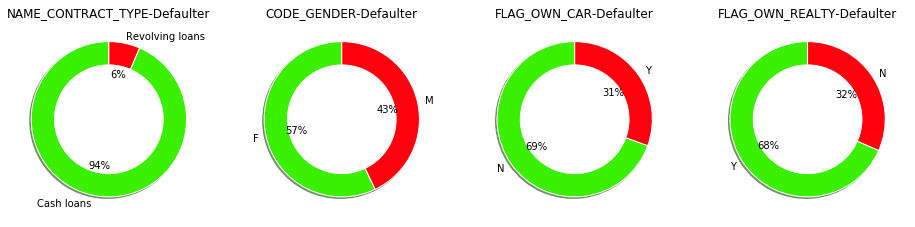

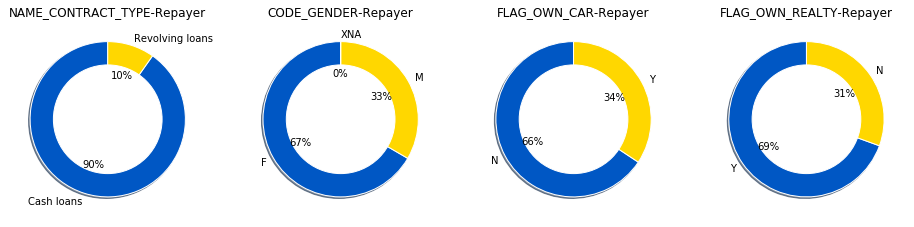

In [20]:
# Graphics of flag fetures 
default = app_train[app_train["TARGET"]==1][[ 'NAME_CONTRACT_TYPE', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY']]
non_default = app_train[app_train["TARGET"]==0][[ 'NAME_CONTRACT_TYPE', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY']]

d_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
d_length = len(d_cols)

fig = plt.figure(figsize=(16,4))
for i,j in itertools.zip_longest(d_cols,range(d_length)):
    plt.subplot(1,4,j+1)
    default[i].value_counts().plot.pie(autopct = "%1.0f%%",colors = sns.color_palette("prism"),startangle = 90,
                                       wedgeprops={"linewidth":1,"edgecolor":"white"},shadow =True)
    circ = plt.Circle((0,0),.7,color="white")
    plt.gca().add_artist(circ)
    plt.ylabel("")
    plt.title(i+"-Defaulter")


fig = plt.figure(figsize=(16,4))
for i,j in itertools.zip_longest(d_cols,range(d_length)):
    plt.subplot(1,4,j+1)
    non_default[i].value_counts().plot.pie(autopct = "%1.0f%%",colors = sns.color_palette("prism",3),startangle = 90,
                                           wedgeprops={"linewidth":1,"edgecolor":"white"},shadow =True)
    circ = plt.Circle((0,0),.7,color="white")
    plt.gca().add_artist(circ)
    plt.ylabel("")
    plt.title(i+"-Repayer")



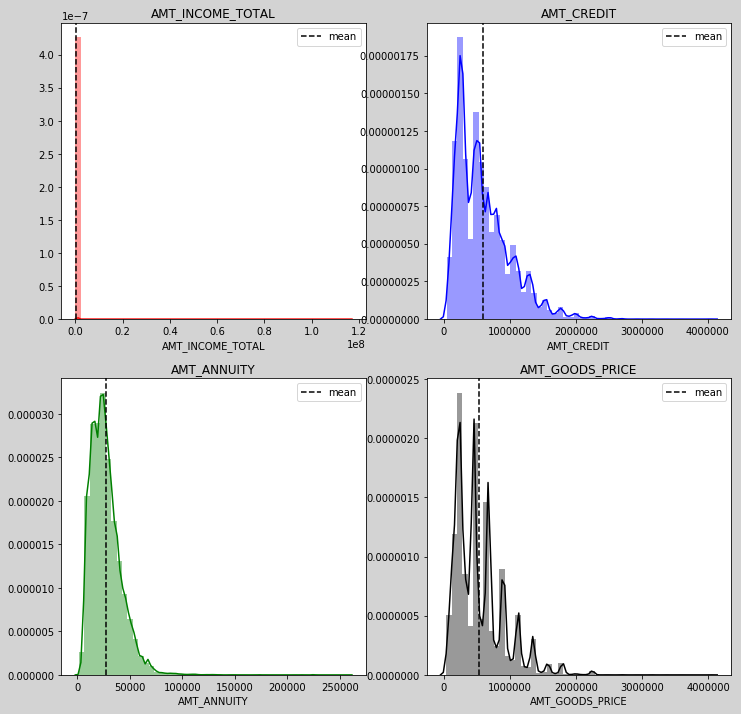

In [21]:
# Distribution of features 'AMT_INCOME_TOTAL', 'AMT_CREDIT','AMT_ANNUITY', 'AMT_GOODS_PRICE'
cols = [ 'AMT_INCOME_TOTAL', 'AMT_CREDIT','AMT_ANNUITY', 'AMT_GOODS_PRICE']
length = len(cols)
cs = ["r","b","g","k"]

ax = plt.figure(figsize=(12,12))
ax.set_facecolor("lightgrey")
for i,j,k in itertools.zip_longest(cols,range(length),cs):
    plt.subplot(2,2,j+1)
    sns.distplot(app_train[app_train[i].notnull()][i],color=k)
    plt.axvline(app_train[i].mean(),label = "mean",linestyle="dashed",color="k")
    plt.legend(loc="best")
    plt.title(i)
    plt.subplots_adjust(hspace = .2)

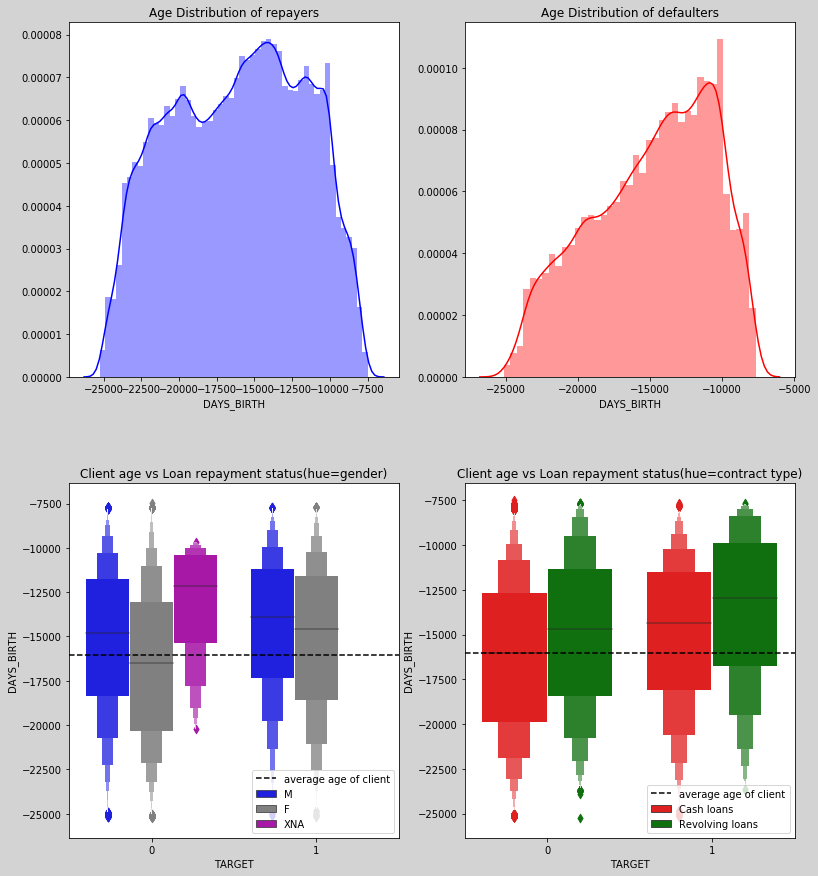

In [22]:
# Client age vs Loan repayment status

fig = plt.figure(figsize=(13,15))

plt.subplot(221)
sns.distplot(app_train[app_train["TARGET"]==0]["DAYS_BIRTH"],color="b")
plt.title("Age Distribution of repayers")

plt.subplot(222)
sns.distplot(app_train[app_train["TARGET"]==1]["DAYS_BIRTH"],color="r")
plt.title("Age Distribution of defaulters")

plt.subplot(223)
sns.lvplot(app_train["TARGET"],app_train["DAYS_BIRTH"],hue=app_train["CODE_GENDER"],palette=["b","grey","m"])
plt.axhline(app_train["DAYS_BIRTH"].mean(),linestyle="dashed",color="k",label ="average age of client")
plt.legend(loc="lower right")
plt.title("Client age vs Loan repayment status(hue=gender)")

plt.subplot(224)
sns.lvplot(app_train["TARGET"],app_train["DAYS_BIRTH"],hue=app_train["NAME_CONTRACT_TYPE"],palette=["r","g"])
plt.axhline(app_train["DAYS_BIRTH"].mean(),linestyle="dashed",color="k",label ="average age of client")
plt.legend(loc="lower right")
plt.title("Client age vs Loan repayment status(hue=contract type)")

plt.subplots_adjust(wspace = .2,hspace = .3)

fig.set_facecolor("lightgrey")

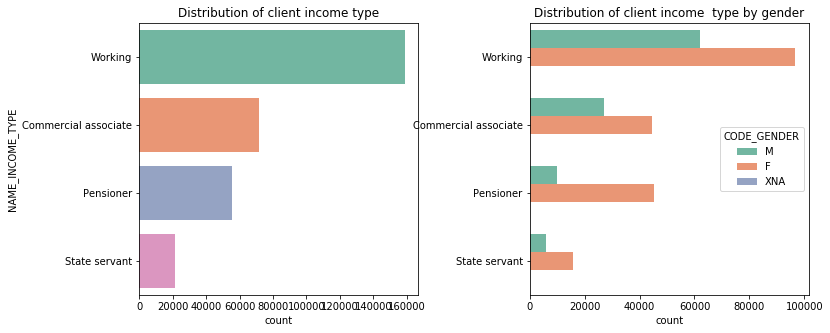

In [23]:
#Distribution of client income  type by gender
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.countplot(y=app_train["NAME_INCOME_TYPE"],palette="Set2",order=app_train["NAME_INCOME_TYPE"].value_counts().index[:4])
plt.title("Distribution of client income type")

plt.subplot(122)
sns.countplot(y=app_train["NAME_INCOME_TYPE"],
              hue=app_train["CODE_GENDER"],
              palette="Set2",
              order=app_train["NAME_INCOME_TYPE"].value_counts().index[:4])
plt.ylabel("")
plt.title("Distribution of client income  type by gender")
plt.subplots_adjust(wspace = .4)

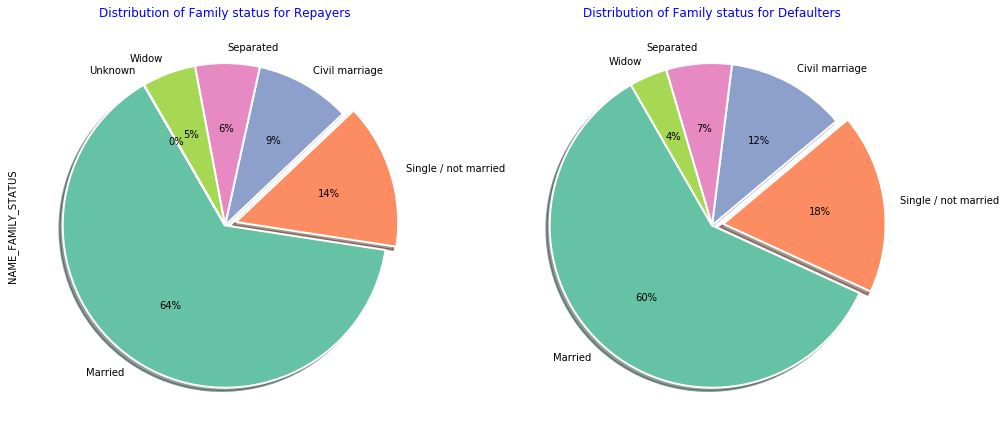

In [24]:
# Distribution of Family status for Defaulters
plt.figure(figsize=(16,8))
plt.subplot(121)
app_train[app_train["TARGET"]==0]["NAME_FAMILY_STATUS"].value_counts().plot.pie(autopct = "%1.0f%%",
                                                             startangle=120,colors = sns.color_palette("Set2",7),
                                              wedgeprops={"linewidth":2,"edgecolor":"white"},shadow =True,explode=[0,.07,0,0,0,0])

plt.title("Distribution of Family status for Repayers",color="b")

plt.subplot(122)
app_train[app_train["TARGET"]==1]["NAME_FAMILY_STATUS"].value_counts().plot.pie(autopct = "%1.0f%%",
                                                    startangle=120,colors = sns.color_palette("Set2",7),
                                              wedgeprops={"linewidth":2,"edgecolor":"white"},shadow =True,explode=[0,.07,0,0,0])


plt.title("Distribution of Family status for Defaulters",color="b")
plt.ylabel("")
plt.show()



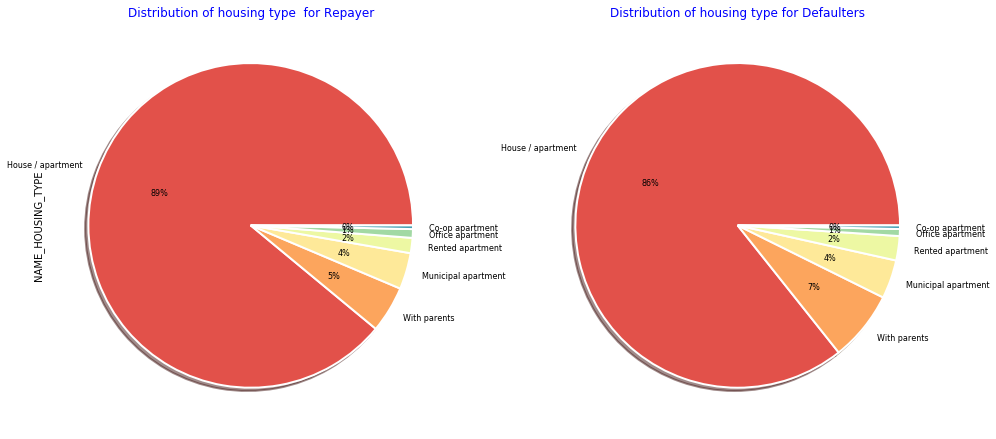

In [25]:
#Distribution of housing type for Defaulters
plt.figure(figsize=(16,8))
plt.subplot(121)
app_train[app_train["TARGET"]==0]["NAME_HOUSING_TYPE"].value_counts().plot.pie(autopct = "%1.0f%%",fontsize=8,
                                                             colors = sns.color_palette("Spectral"),
                                              wedgeprops={"linewidth":2,"edgecolor":"white"},shadow =True)

plt.title("Distribution of housing type  for Repayer",color="b")

plt.subplot(122)
app_train[app_train["TARGET"]==1]["NAME_HOUSING_TYPE"].value_counts().plot.pie(autopct = "%1.0f%%",fontsize=8,
                                                    colors = sns.color_palette("Spectral"),
                                              wedgeprops={"linewidth":2,"edgecolor":"white"},shadow =True)


plt.title("Distribution of housing type for Defaulters",color="b")
plt.ylabel("")
plt.show()


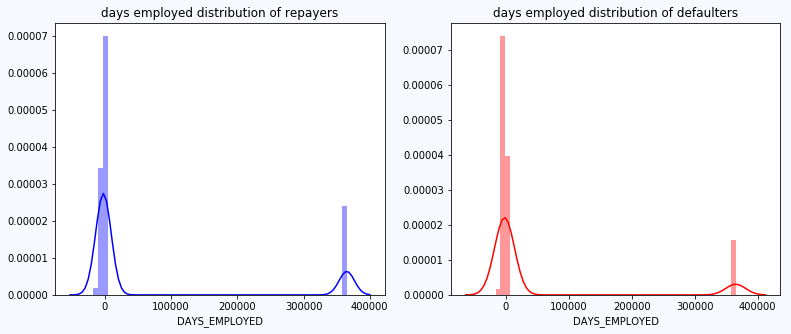

In [26]:
# days employed distribution of defaulters
fig = plt.figure(figsize=(13,5))

plt.subplot(121)
sns.distplot(app_train[app_train["TARGET"]==0]["DAYS_EMPLOYED"],color="b")
plt.title("days employed distribution of repayers")

plt.subplot(122)
sns.distplot(app_train[app_train["TARGET"]==1]["DAYS_EMPLOYED"],color="r")
plt.title("days employed distribution of defaulters")

fig.set_facecolor("ghostwhite")

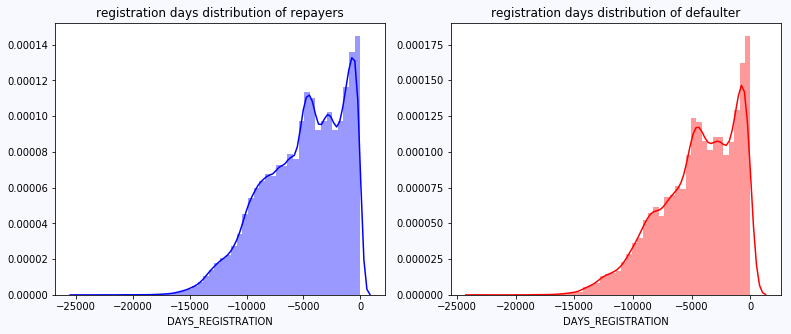

In [27]:
# Distribution of registration days distribution of repayers
fig = plt.figure(figsize=(13,5))

plt.subplot(121)
sns.distplot(app_train[app_train["TARGET"]==0]["DAYS_REGISTRATION"],color="b")
plt.title("registration days distribution of repayers")

plt.subplot(122)
sns.distplot(app_train[app_train["TARGET"]==1]["DAYS_REGISTRATION"],color="r")
plt.title("registration days distribution of defaulter")

fig.set_facecolor("ghostwhite")


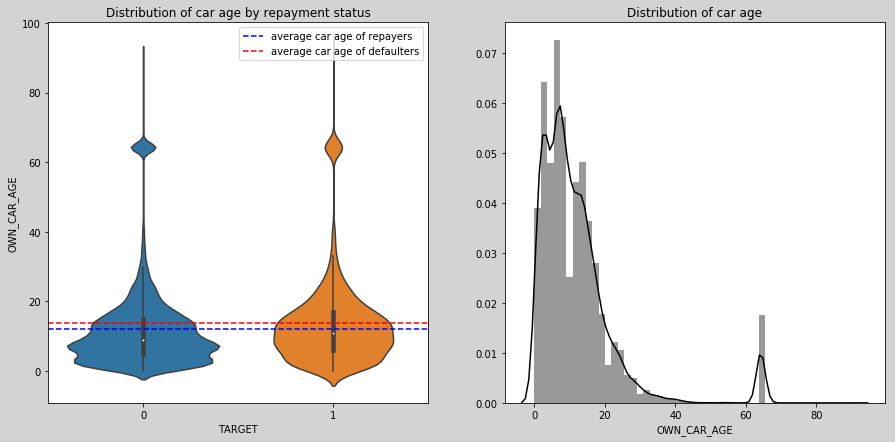

In [28]:
# Distribution of car age 
fig = plt.figure(figsize=(15,7))
plt.subplot(121)
sns.violinplot(y = app_train[app_train["OWN_CAR_AGE"].notnull()]["OWN_CAR_AGE"],
               x=app_train[app_train["OWN_CAR_AGE"].notnull()]["TARGET"])
plt.axhline(app_train[(app_train["OWN_CAR_AGE"].notnull())&(app_train["TARGET"] ==0)]["OWN_CAR_AGE"].mean(),color="b",
            linestyle="dashed",label = "average car age of repayers")
plt.axhline(app_train[(app_train["OWN_CAR_AGE"].notnull())&(app_train["TARGET"] ==1)]["OWN_CAR_AGE"].mean(),color="r",
            linestyle="dashed",label = "average car age of defaulters")
plt.legend(loc="best")
plt.title("Distribution of car age by repayment status")

plt.subplot(122)
sns.distplot(app_train[app_train["OWN_CAR_AGE"].notnull()]["OWN_CAR_AGE"],color="k")
plt.title("Distribution of car age")

fig.set_facecolor("lightgrey")


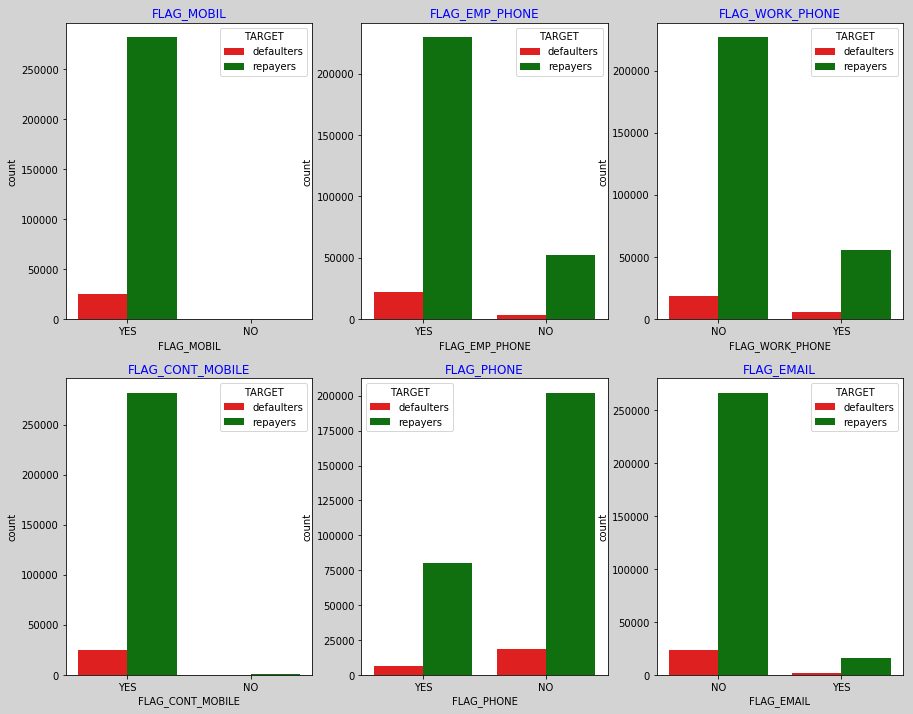

In [29]:
# Dsitribution of features 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE'
x   = app_train[['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL',"TARGET"]]
x["TARGET"] = x["TARGET"].replace({0:"repayers",1:"defaulters"})
x  = x.replace({1:"YES",0:"NO"})

cols = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL']
length = len(cols)

fig = plt.figure(figsize=(15,12))
fig.set_facecolor("lightgrey")

for i,j in itertools.zip_longest(cols,range(length)):
    plt.subplot(2,3,j+1)
    sns.countplot(x[i],hue=x["TARGET"],palette=["r","g"])
    plt.title(i,color="b")

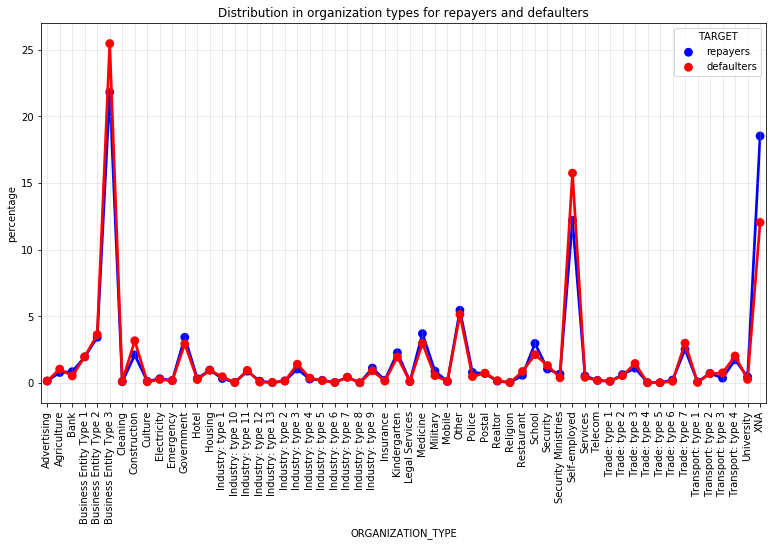

In [30]:

#Distribution in organization types for repayers and defaulters
org = app_train.groupby("TARGET").agg({"ORGANIZATION_TYPE":"value_counts"})
org = org.rename(columns = {"ORGANIZATION_TYPE":"value_counts"}).reset_index()
org_0 = org[org["TARGET"] == 0]
org_1 = org[org["TARGET"] == 1]
org_0["percentage"] = org_0["value_counts"]*100/org_0["value_counts"].sum()
org_1["percentage"] = org_1["value_counts"]*100/org_1["value_counts"].sum()

organization = pd.concat([org_0,org_1],axis=0)
organization = organization.sort_values(by="ORGANIZATION_TYPE",ascending=True)

organization["TARGET"] = organization["TARGET"].replace({0:"repayers",1:"defaulters"})

organization
plt.figure(figsize=(13,7))
ax = sns.pointplot("ORGANIZATION_TYPE","percentage",
                   data=organization,hue="TARGET",palette=["b","r"])
plt.xticks(rotation=90)
plt.grid(True,alpha=.3)
ax.set_facecolor("w")
ax.set_title("Distribution in organization types for repayers and defaulters")
plt.show()



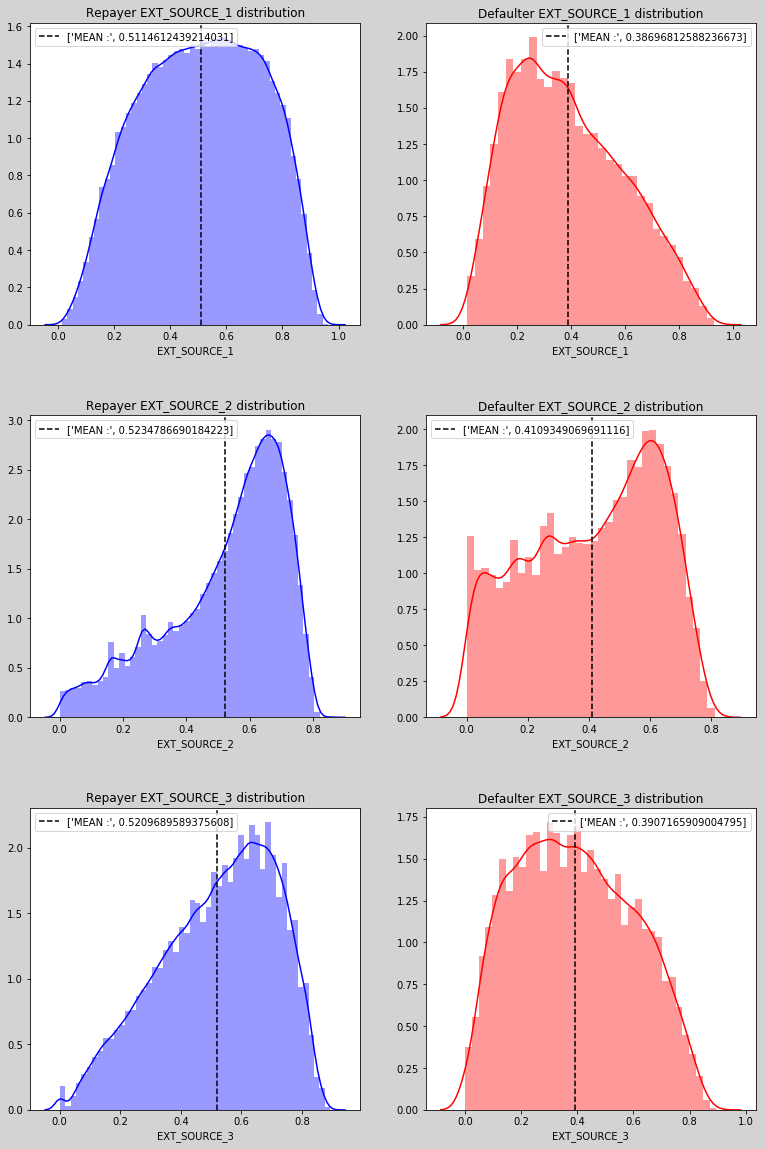

In [31]:
# Distribution of "EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"
app_train[["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]]

fig = plt.figure(figsize=(13,20))

plt.subplot(321)
sns.distplot(app_train[(app_train["EXT_SOURCE_1"].notnull()) & (app_train["TARGET"] ==0 )]["EXT_SOURCE_1"],color="b")
plt.axvline(app_train[(app_train["EXT_SOURCE_1"].notnull()) & (app_train["TARGET"] ==0 )]["EXT_SOURCE_1"].mean(),
           linestyle="dashed",color="k",
           label = ["MEAN :",app_train[(app_train["EXT_SOURCE_1"].notnull()) & (app_train["TARGET"] ==0 )]["EXT_SOURCE_1"].mean()])
plt.legend(loc="best")
plt.title("Repayer EXT_SOURCE_1 distribution")

plt.subplot(322)
sns.distplot(app_train[(app_train["EXT_SOURCE_1"].notnull()) & (app_train["TARGET"] ==1 )]["EXT_SOURCE_1"],color="r")
plt.axvline(app_train[(app_train["EXT_SOURCE_1"].notnull()) & (app_train["TARGET"] ==1 )]["EXT_SOURCE_1"].mean(),
           linestyle="dashed",color="k",
           label = ["MEAN :",app_train[(app_train["EXT_SOURCE_1"].notnull()) & (app_train["TARGET"] ==1 )]["EXT_SOURCE_1"].mean()])
plt.legend(loc="best")
plt.title("Defaulter EXT_SOURCE_1 distribution")
####
plt.subplot(323)
sns.distplot(app_train[(app_train["EXT_SOURCE_2"].notnull()) & (app_train["TARGET"] ==0 )]["EXT_SOURCE_2"],color="b")
plt.axvline(app_train[(app_train["EXT_SOURCE_2"].notnull()) & (app_train["TARGET"] ==0 )]["EXT_SOURCE_2"].mean(),
           linestyle="dashed",color="k",
           label = ["MEAN :",app_train[(app_train["EXT_SOURCE_2"].notnull()) & (app_train["TARGET"] ==0 )]["EXT_SOURCE_2"].mean()])
plt.legend(loc="best")
plt.title("Repayer EXT_SOURCE_2 distribution")

plt.subplot(324)
sns.distplot(app_train[(app_train["EXT_SOURCE_2"].notnull()) & (app_train["TARGET"] ==1 )]["EXT_SOURCE_2"],color="r")
plt.axvline(app_train[(app_train["EXT_SOURCE_2"].notnull()) & (app_train["TARGET"] ==1 )]["EXT_SOURCE_2"].mean(),
           linestyle="dashed",color="k",
           label = ["MEAN :",app_train[(app_train["EXT_SOURCE_2"].notnull()) & (app_train["TARGET"] ==1 )]["EXT_SOURCE_2"].mean()])
plt.legend(loc="best")
plt.title("Defaulter EXT_SOURCE_2 distribution")

###
plt.subplot(325)
sns.distplot(app_train[(app_train["EXT_SOURCE_3"].notnull()) & (app_train["TARGET"] ==0 )]["EXT_SOURCE_3"],color="b")
plt.axvline(app_train[(app_train["EXT_SOURCE_3"].notnull()) & (app_train["TARGET"] ==0 )]["EXT_SOURCE_3"].mean(),
           linestyle="dashed",color="k",
           label = ["MEAN :",app_train[(app_train["EXT_SOURCE_3"].notnull()) & (app_train["TARGET"] ==0 )]["EXT_SOURCE_3"].mean()])
plt.legend(loc="best")
plt.title("Repayer EXT_SOURCE_3 distribution")

plt.subplot(326)
sns.distplot(app_train[(app_train["EXT_SOURCE_3"].notnull()) & (app_train["TARGET"] ==1 )]["EXT_SOURCE_3"],color="r")
plt.axvline(app_train[(app_train["EXT_SOURCE_3"].notnull()) & (app_train["TARGET"] ==1 )]["EXT_SOURCE_3"].mean(),
           linestyle="dashed",color="k",
           label = ["MEAN :",app_train[(app_train["EXT_SOURCE_3"].notnull()) & (app_train["TARGET"] ==1 )]["EXT_SOURCE_3"].mean()])
plt.legend(loc="best")
plt.title("Defaulter EXT_SOURCE_3 distribution")

plt.subplots_adjust(hspace = .3)
fig.set_facecolor("lightgrey")

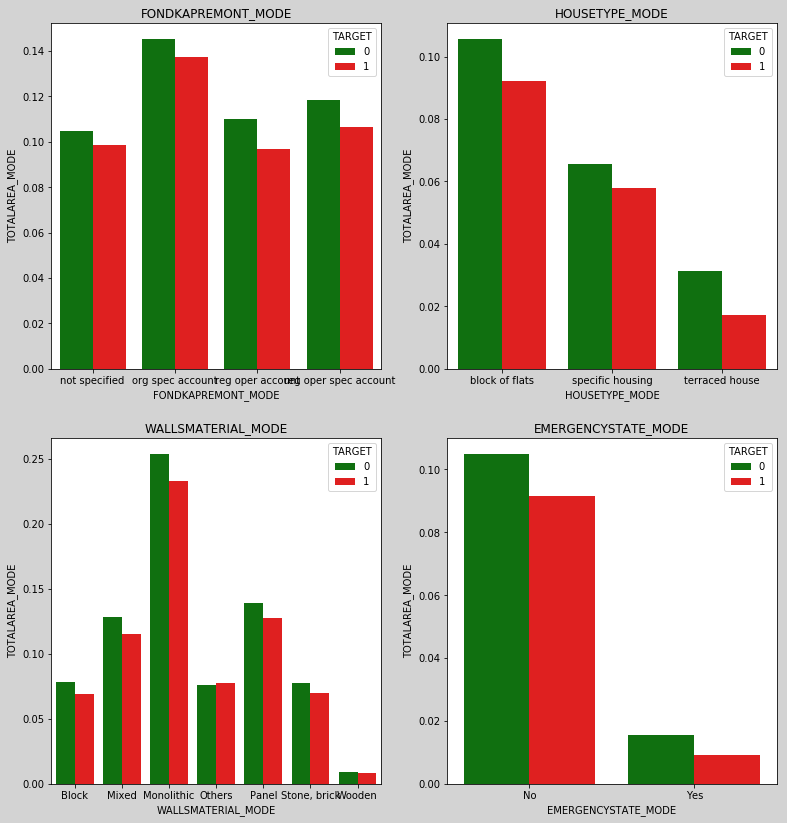

In [32]:
# Distribution of  'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
cs = [ 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
length = len(cs)

fig = plt.figure(figsize=(13,14))
fig.set_facecolor("lightgrey")
for i,j in itertools.zip_longest(cs,range(length)):
    plt.subplot(2,2,j+1)
    ax = sns.barplot(i,"TOTALAREA_MODE",data=app_train.groupby(["TARGET",i])["TOTALAREA_MODE"].mean().reset_index(),
                hue="TARGET",palette=["g","r"])
    ax.set_facecolor("w")
    plt.title(i)

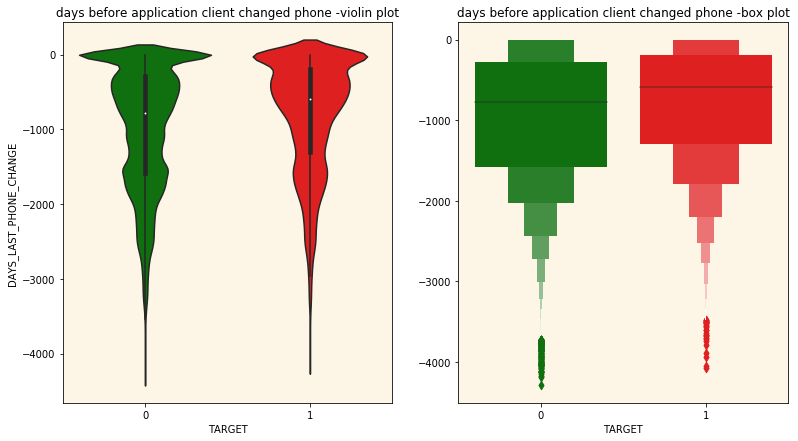

In [33]:
plt.figure(figsize=(13,7))
plt.subplot(121)
ax = sns.violinplot(app_train["TARGET"],
                    app_train["DAYS_LAST_PHONE_CHANGE"],palette=["g","r"])
ax.set_facecolor("oldlace")
ax.set_title("days before application client changed phone -violin plot")
plt.subplot(122)
ax1 = sns.lvplot(app_train["TARGET"],
                 app_train["DAYS_LAST_PHONE_CHANGE"],palette=["g","r"])
ax1.set_facecolor("oldlace")
ax1.set_ylabel("")
ax1.set_title("days before application client changed phone -box plot")
plt.subplots_adjust(wspace = .2)



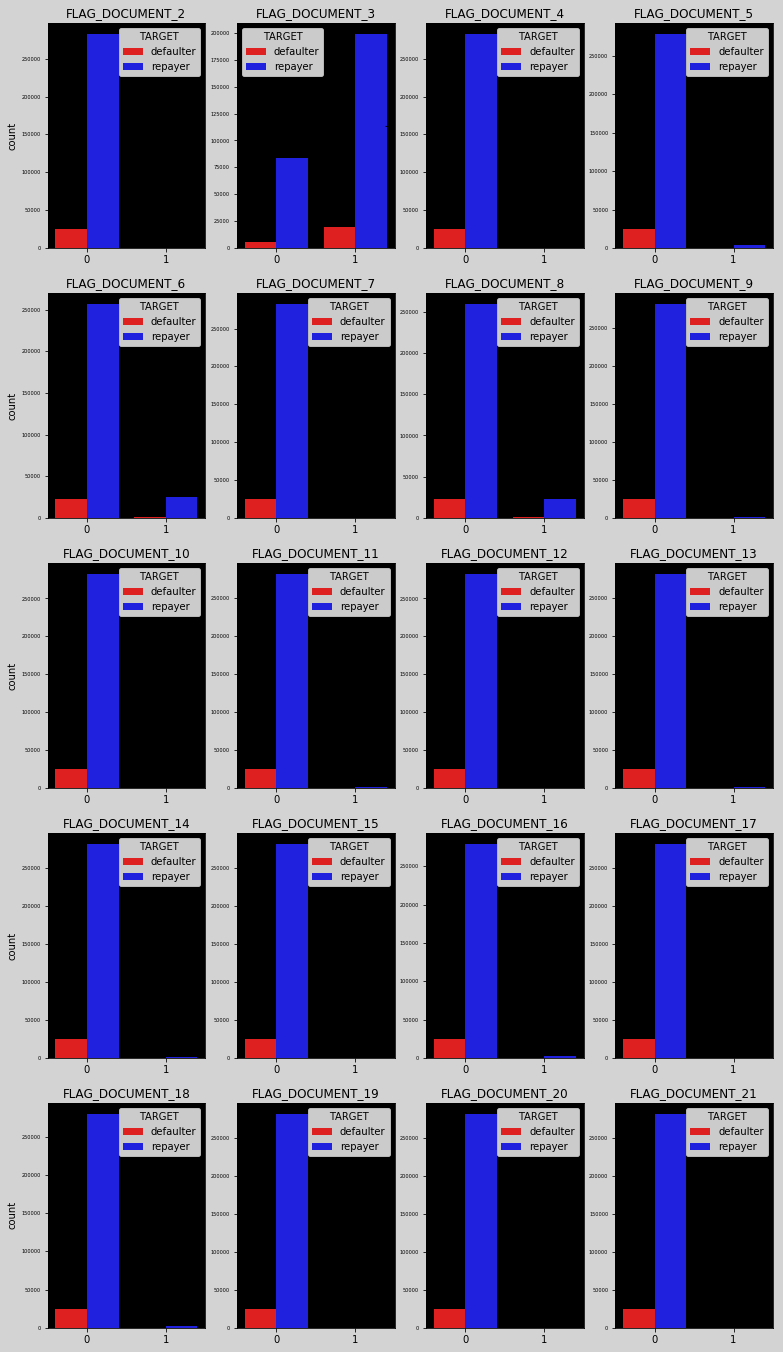

In [34]:
cols = [ 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

df_flag = app_train[cols+["TARGET"]]

length = len(cols)

df_flag["TARGET"] = df_flag["TARGET"].replace({1:"defaulter",0:"repayer"})

fig = plt.figure(figsize=(13,24))
fig.set_facecolor("lightgrey")
for i,j in itertools.zip_longest(cols,range(length)):
    plt.subplot(5,4,j+1)
    ax = sns.countplot(df_flag[i],hue=df_flag["TARGET"],palette=["r","b"])
    plt.yticks(fontsize=5)
    plt.xlabel("")
    plt.title(i)
    ax.set_facecolor("k")

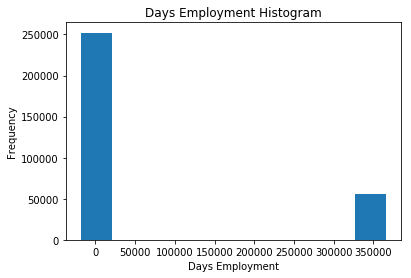

In [35]:
# Histogram of DAYS_EMPLOYED
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');


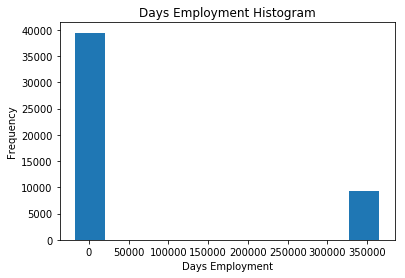

In [36]:
app_test['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [37]:
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
app_test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

### Observing object type variable

In [38]:
app_train = app_train.drop(columns = 'type')
app_test = app_test.drop(columns = 'type')

In [39]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created

Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

In [40]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


 One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns. 

In [41]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)


Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [42]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [43]:
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100001,0,0,1,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,0,0,0,0,0,0,1,0,1,0
1,100005,0,0,1,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,0,0,0,0,0,0,0,0,0,0
2,100013,0,1,1,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,0,0,0,0,0,0,0,0,0,0
3,100028,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,0,0,0,0,0,1,0,0,1,0
4,100038,0,1,0,1,180000.0,625500.0,32067.0,625500.0,0.010032,...,0,0,0,0,0,0,0,0,0,0


In [44]:
#Create some infomration that can be used in future 

In [45]:
app_train['DAYS_EMPLOYED_PERC'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']
app_train['INCOME_CREDIT_PERC'] = app_train['AMT_INCOME_TOTAL'] / app_train['AMT_CREDIT']
app_train['INCOME_PER_PERSON'] = app_train['AMT_INCOME_TOTAL'] / app_train['CNT_FAM_MEMBERS']
app_train['ANNUITY_INCOME_PERC'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['PAYMENT_RATE'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']

app_test['DAYS_EMPLOYED_PERC'] = app_test['DAYS_EMPLOYED'] / app_test['DAYS_BIRTH']
app_test['INCOME_CREDIT_PERC'] = app_test['AMT_INCOME_TOTAL'] / app_test['AMT_CREDIT']
app_test['INCOME_PER_PERSON'] = app_test['AMT_INCOME_TOTAL'] / app_test['CNT_FAM_MEMBERS']
app_test['ANNUITY_INCOME_PERC'] = app_test['AMT_ANNUITY'] / app_test['AMT_INCOME_TOTAL']
app_test['PAYMENT_RATE'] = app_test['AMT_ANNUITY'] / app_test['AMT_CREDIT']

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 245)
Testing Features shape:  (48744, 244)


# Building New Features

In [46]:
#teste = app_train['DAYS_BIRTH']/360.25 * -1

app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])


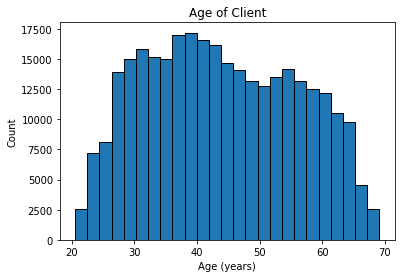

In [47]:
# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

In [48]:
app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,1,0,1,0,1,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,1,0,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623


Exterior Sources


The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source". 

In [49]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs


,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


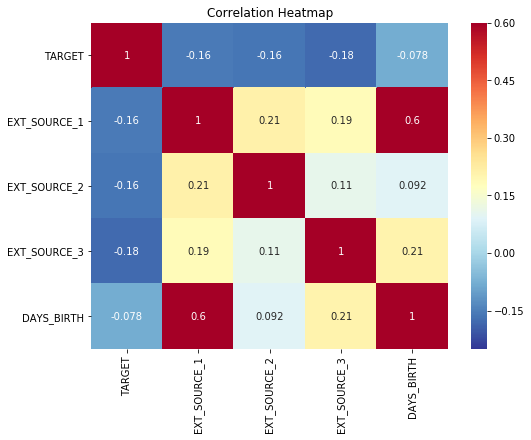

In [50]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

## Polynomial features

One simple feature construction method is called polynomial features. In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables EXT_SOURCE_1^2 and EXT_SOURCE_2^2 and also variables such as EXT_SOURCE_1 x EXT_SOURCE_2, EXT_SOURCE_1 x EXT_SOURCE_2^2, EXT_SOURCE_1^2 x EXT_SOURCE_2^2, and so on. These features that are a combination of multiple individual variables are called interaction terms because they capture the interactions between variables. In other words, while two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. 

In [51]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)


In [52]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)


Polynomial Features shape:  (307511, 35)


In [53]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]


['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [54]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))


EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [55]:
poly_features.head()

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,...,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,TARGET
0,1.0,0.083037,0.262949,0.139376,9461.0,0.006895,0.021834,0.011573,785.612748,0.069142,...,0.009637,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11,1
1,1.0,0.311267,0.622246,0.535276,16765.0,0.096887,0.193685,0.166614,5218.396475,0.387190,...,0.207254,6491.237078,0.178286,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12,0
2,1.0,0.505998,0.555912,0.729567,19046.0,0.256034,0.281290,0.369159,9637.236584,0.309038,...,0.225464,5885.942404,0.295894,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12,0
3,1.0,0.505998,0.650442,0.535276,19005.0,0.256034,0.329122,0.270849,9616.490669,0.423074,...,0.226462,8040.528832,0.186365,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12,0
4,1.0,0.505998,0.322738,0.535276,19932.0,0.256034,0.163305,0.270849,10085.550751,0.104160,...,0.055754,2076.117157,0.092471,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12,0


In [56]:
app_train_extr_aux = app_train[['SK_ID_CURR']]
app_train_extr_aux = pd.DataFrame(app_train_extr_aux)
app_train_extr_aux.head()

,SK_ID_CURR
0,100002
1,100003
2,100004
3,100006
4,100007


In [57]:
app_test_extr_aux = app_test[['SK_ID_CURR']]
app_test_extr_aux.head()

,SK_ID_CURR
0,100001
1,100005
2,100013
3,100028
4,100038


In [58]:
# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
poly_features = poly_features.drop(columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET'])

app_train = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')
app_train['TARGET'] = target
app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.018181,0.009637,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.240927,0.207254,6491.237078,0.178286,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.171798,0.225464,5885.942404,0.295894,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.275185,0.226462,8040.528832,0.186365,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.033616,0.055754,2076.117157,0.092471,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12


In [59]:
# Merge polynomial features into test dataframe
poly_features['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test = app_test.merge(poly_features, on = 'SK_ID_CURR', how = 'left')
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3
0,100001,0,0,1,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,0.018181,0.009637,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11
1,100005,0,0,1,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,0.240927,0.207254,6491.237078,0.178286,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12
2,100013,0,1,1,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,0.171798,0.225464,5885.942404,0.295894,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12
3,100028,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,0.275185,0.226462,8040.528832,0.186365,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12
4,100038,0,1,0,1,180000.0,625500.0,32067.0,625500.0,0.010032,...,0.033616,0.055754,2076.117157,0.092471,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12


In [60]:
# Align the dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = target

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train.shape)
print('Testing data with polynomial features shape:  ', app_test.shape)


Training data with polynomial features shape:  (307511, 276)
Testing data with polynomial features shape:   (48744, 275)



## Correlated features

An important consideration is the drop correlated features


In [61]:
# Threshold for removing correlated variables
threshold = 0.6

# Absolute value correlation matrix
corr_matrix = app_train.corr().abs()
corr_matrix.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,TARGET
SK_ID_CURR,1.000000,0.001654,0.001216,0.000703,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,...,0.001527,0.001213,0.001338,0.001149,0.001538,0.000409,0.000139,0.000156,0.000727,0.002108
NAME_CONTRACT_TYPE,0.001654,1.000000,0.004022,0.067177,0.029998,0.003531,0.221648,0.241544,0.185850,0.026867,...,0.008925,0.021501,0.004027,0.029004,0.052017,0.005397,0.038581,0.065370,0.076662,0.030896
FLAG_OWN_CAR,0.001216,0.004022,1.000000,0.002817,0.102023,0.083383,0.116225,0.141588,0.120310,0.041314,...,0.033728,0.009524,0.015976,0.035909,0.080086,0.010298,0.066055,0.118726,0.147132,0.021851
FLAG_OWN_REALTY,0.000703,0.067177,0.002817,1.000000,0.002366,0.002934,0.039270,0.005225,0.045537,0.015175,...,0.019060,0.048878,0.029366,0.067948,0.087902,0.037624,0.077662,0.106078,0.111843,0.006148
CNT_CHILDREN,0.001129,0.029998,0.102023,0.002366,1.000000,0.012882,0.002145,0.021374,0.001827,0.025573,...,0.035572,0.152448,0.039596,0.175433,0.277317,0.037723,0.170776,0.292440,0.354855,0.019187


In [62]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,TARGET
SK_ID_CURR,NaN,0.001654,0.001216,0.000703,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,...,0.001527,0.001213,0.001338,0.001149,0.001538,0.000409,0.000139,0.000156,0.000727,0.002108
NAME_CONTRACT_TYPE,NaN,NaN,0.004022,0.067177,0.029998,0.003531,0.221648,0.241544,0.185850,0.026867,...,0.008925,0.021501,0.004027,0.029004,0.052017,0.005397,0.038581,0.065370,0.076662,0.030896
FLAG_OWN_CAR,NaN,NaN,NaN,0.002817,0.102023,0.083383,0.116225,0.141588,0.120310,0.041314,...,0.033728,0.009524,0.015976,0.035909,0.080086,0.010298,0.066055,0.118726,0.147132,0.021851
FLAG_OWN_REALTY,NaN,NaN,NaN,NaN,0.002366,0.002934,0.039270,0.005225,0.045537,0.015175,...,0.019060,0.048878,0.029366,0.067948,0.087902,0.037624,0.077662,0.106078,0.111843,0.006148
CNT_CHILDREN,NaN,NaN,NaN,NaN,NaN,0.012882,0.002145,0.021374,0.001827,0.025573,...,0.035572,0.152448,0.039596,0.175433,0.277317,0.037723,0.170776,0.292440,0.354855,0.019187


In [63]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 86 columns to remove.


In [64]:
to_drop

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'FLAG_EMP_PHONE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT_W_CITY',
 'LIVE_REGION_NOT_WORK_REGION',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'BASEMENTAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SO

In [65]:
app_train_corr = app_train.drop(columns = to_drop)
app_test_corr = app_test.drop(columns = to_drop)

print('Training shape: ', app_train_corr.shape)
print('Testing shape: ', app_test_corr.shape)


Training shape:  (307511, 190)
Testing shape:  (48744, 189)


In [66]:
app_train_corr.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,ANNUITY_INCOME_PERC,PAYMENT_RATE,1,TARGET
0,100002,0,0,1,0,202500.0,406597.5,0.018801,9461,-637.0,...,0,0,0,1,0,0,0.121978,0.060749,1.0,1
1,100003,0,0,0,0,270000.0,1293502.5,0.003541,16765,-1188.0,...,0,0,0,0,0,0,0.132217,0.027598,1.0,0
2,100004,1,1,1,0,67500.0,135000.0,0.010032,19046,-225.0,...,0,0,0,0,0,0,0.100000,0.050000,1.0,0
3,100006,0,0,1,0,135000.0,312682.5,0.008019,19005,-3039.0,...,0,0,0,0,0,0,0.219900,0.094941,1.0,0
4,100007,0,0,1,0,121500.0,513000.0,0.028663,19932,-3038.0,...,0,0,0,0,0,0,0.179963,0.042623,1.0,0


# Missing Values

### Delete missing values

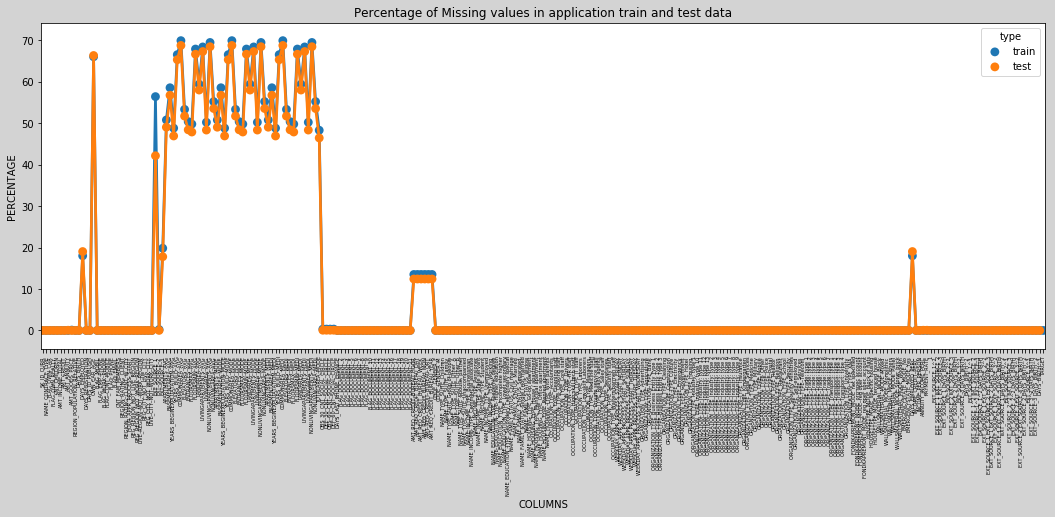

In [67]:
#Percentage of Missing values in application train and test data
fig = plt.figure(figsize=(18,6))
miss_train = pd.DataFrame((app_train.isnull().sum())*100/app_train.shape[0]).reset_index()
miss_test = pd.DataFrame((app_test.isnull().sum())*100/app_test.shape[0]).reset_index()
miss_train["type"] = "train"
miss_test["type"]  =  "test"
missing = pd.concat([miss_train,miss_test],axis=0)
ax = sns.pointplot("index",0,data=missing,hue="type")
plt.xticks(rotation =90,fontsize =5)
plt.title("Percentage of Missing values in application train and test data")
plt.ylabel("PERCENTAGE")
plt.xlabel("COLUMNS")
ax.set_facecolor("w")
fig.set_facecolor("lightgrey")


In [68]:
# Train missing values (in percent)
train_missing = (app_train_corr.isnull().sum() / len(app_train_corr)).sort_values(ascending = False)
train_missing.head()

COMMONAREA_AVG             0.698723
NONLIVINGAPARTMENTS_AVG    0.694330
YEARS_BUILD_AVG            0.664978
OWN_CAR_AGE                0.659908
LANDAREA_AVG               0.593767
dtype: float64

In [69]:
# Train missing values (in percent)
test_missing = (app_test_corr.isnull().sum() / len(app_test_corr)).sort_values(ascending = False)
test_missing.head()

COMMONAREA_AVG             0.687161
NONLIVINGAPARTMENTS_AVG    0.684125
OWN_CAR_AGE                0.662892
YEARS_BUILD_AVG            0.652757
LANDAREA_AVG               0.579641
dtype: float64

In [70]:
# Identify missing values above threshold
train_missing_ = train_missing.index[train_missing > 0.6]

test_missing_  = test_missing.index[test_missing > 0.6]

all_missing = list(set(set(train_missing_) | set(test_missing_)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 4 columns with more than 75% missing values


In [71]:
# Need to save the labels because aligning will remove this column

app_train_corr_missing = app_train_corr.drop(columns = all_missing)
app_test_corr_missing = app_test_corr.drop(columns = all_missing)

#train, test = train.align(test, join = 'inner', axis = 1)

print('Training set full shape: ', app_train_corr_missing.shape)
print('Testing set full shape: ' , app_test_corr_missing.shape)

Training set full shape:  (307511, 186)
Testing set full shape:  (48744, 185)


In [72]:
app_train_corr_missing.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,ANNUITY_INCOME_PERC,PAYMENT_RATE,1,TARGET
0,100002,0,0,1,0,202500.0,406597.5,0.018801,9461,-637.0,...,0,0,0,1,0,0,0.121978,0.060749,1.0,1
1,100003,0,0,0,0,270000.0,1293502.5,0.003541,16765,-1188.0,...,0,0,0,0,0,0,0.132217,0.027598,1.0,0
2,100004,1,1,1,0,67500.0,135000.0,0.010032,19046,-225.0,...,0,0,0,0,0,0,0.100000,0.050000,1.0,0
3,100006,0,0,1,0,135000.0,312682.5,0.008019,19005,-3039.0,...,0,0,0,0,0,0,0.219900,0.094941,1.0,0
4,100007,0,0,1,0,121500.0,513000.0,0.028663,19932,-3038.0,...,0,0,0,0,0,0,0.179963,0.042623,1.0,0


 # Logistic Regression Implementation¶

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

In [73]:
# Features importance
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train_corr_missing:
    train = app_train_corr_missing.drop(columns = ['TARGET'])
else:
    train = app_train_corr_missing.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test_corr_missing.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)


Training data shape:  (307511, 185)
Testing data shape:  (48744, 185)


Using Logistic Regression as Banchmark

In [74]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [75]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [76]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.067457
1,100005,0.127558
2,100013,0.073920
3,100028,0.069684
4,100038,0.128591


In [79]:
#submit.to_csv(submission+'log_reg_baseline.csv', index = False)

# To get the value of AUC we need submit the file on Kaggle web sit

## Trie to run RandomForestClassifier to get features importance

In [78]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)	

# Train on the training data
random_forest.fit(train, target)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


In [79]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:16]))), 
            df['importance_normalized'].head(16), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:16]))))
    ax.set_yticklabels(df['feature'].head(16))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df



In [80]:
feature_importances_ = feature_importances[1:]

In [81]:
feature_importances_

,feature,importance
1,NAME_CONTRACT_TYPE,0.002132
2,FLAG_OWN_CAR,0.006265
3,FLAG_OWN_REALTY,0.007061
4,CNT_CHILDREN,0.010743
5,AMT_INCOME_TOTAL,0.031344
6,AMT_CREDIT,0.036936
7,REGION_POPULATION_RELATIVE,0.032547
8,DAYS_BIRTH,0.042443
9,DAYS_EMPLOYED,0.039240
10,DAYS_REGISTRATION,0.041433


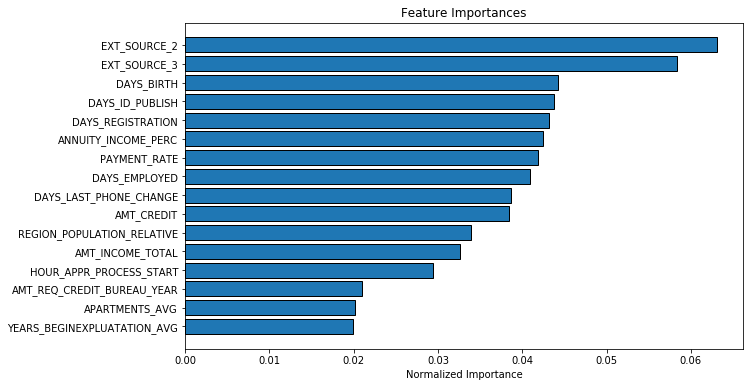

In [83]:
feature_importances_sorted = plot_feature_importances(feature_importances_)

In [84]:
import gc
gc.enable()
del app_train
#,app_test
#,poly_features
#,poly_features_test
#,poly_corrs
#,app_train_corr
#,app_test_corr
#,train_missing
#,test_missing
gc.collect()

6893

In [85]:
app_train_corr_missing.to_csv(out_path+"app_train_corr_missing.csv", index=False)

In [86]:
app_test_corr_missing.to_csv(out_path+"app_test_corr_missing.csv", index=False)

# Trie to run an algorithm Light GBM 

    First Try

In [92]:
folds = KFold(n_splits=2, shuffle=True, random_state=1001)

In [93]:
# Divide in training/validation and test data
train_df = app_train_corr_missing.copy()
test_df = app_test_corr_missing.copy()
print("Starting LightGBM. Train shape: {}, test shape: {}".format(app_train_corr_missing.shape, app_test_corr_missing.shape))

Starting LightGBM. Train shape: (307511, 186), test shape: (48744, 185)


In [94]:
# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [95]:
# Iterate through each fold
for train_indices, valid_indices in folds.split(train_df[feats],train_df['TARGET']):
        
    # Training data for the fold
    train_features, train_labels = train_df[feats].iloc[train_indices], train_df['TARGET'].iloc[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = train_df[feats].iloc[valid_indices], train_df['TARGET'].iloc[valid_indices]
        
    # Create the model
    model = LGBMClassifier(n_estimators=5000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
    
        
    # Train the model
    model.fit(train_features, train_labels, eval_metric = 'auc',
                eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                eval_names = ['valid', 'train'],
                early_stopping_rounds = 100, verbose = 200)
    
    oof_preds[valid_indices] = model.predict_proba(valid_features, num_iteration=model.best_iteration_)[:, 1]
    sub_preds += model.predict_proba(test_df[feats], num_iteration=model.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = model.feature_importances_
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del model, train_features, train_labels, valid_features, valid_labels
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.811735	train's binary_logloss: 0.537051	valid's auc: 0.75572	valid's binary_logloss: 0.557189
Early stopping, best iteration is:
[143]	train's auc: 0.797154	train's binary_logloss: 0.551013	valid's auc: 0.756351	valid's binary_logloss: 0.565534
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.813516	train's binary_logloss: 0.534974	valid's auc: 0.754963	valid's binary_logloss: 0.55678
Early stopping, best iteration is:
[192]	train's auc: 0.811594	train's binary_logloss: 0.536846	valid's auc: 0.755041	valid's binary_logloss: 0.557872
Full AUC score 0.755642


In [96]:
fold_importance_df

,feature,importance
0,NAME_CONTRACT_TYPE,82
1,FLAG_OWN_CAR,72
2,FLAG_OWN_REALTY,9
3,CNT_CHILDREN,25
4,AMT_INCOME_TOTAL,102
5,AMT_CREDIT,284
6,REGION_POPULATION_RELATIVE,125
7,DAYS_BIRTH,295
8,DAYS_EMPLOYED,371
9,DAYS_REGISTRATION,174


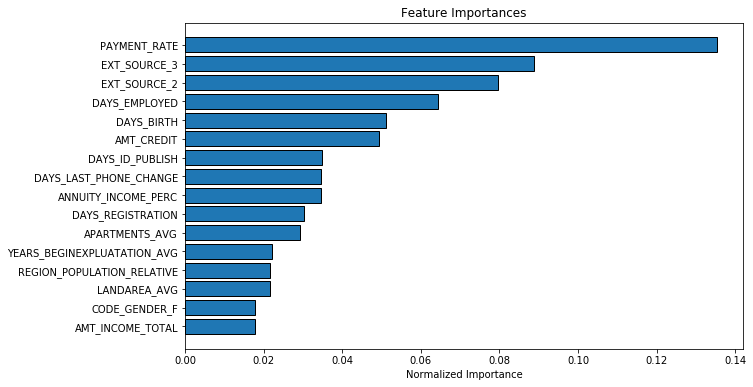

In [97]:
feature_importances_sorted = plot_feature_importances(fold_importance_df)